In [1]:
import pandas as pd
import numpy as np
import src
import warnings
import os
warnings.filterwarnings("ignore", category=FutureWarning)

from pybedtools.bedtool import BedTool
from pybedtools import cleanup

import matplotlib.pyplot as plt
import seaborn as sns

figure_path = src.figures_path / "DI_index"
os.makedirs(figure_path, exist_ok=True)

cleanup()

In [2]:
gm12878_bounds = pd.read_csv(src.processed_data_path / "GM12878_25kb_1Mb_boundary_strength.bed", sep="\t")
gm12878_bounds.columns = src.coords + ['bound_strenght', 'cluster_id']
print("GM12878 bounds:", gm12878_bounds.shape[0])
gm12878_bounds.head()

GM12878 bounds: 6073


,chr,start,end,bound_strenght,cluster_id
0,chr1,1025000,1050000,0.005828,0
1,chr1,1850000,1875000,1.892125,1
2,chr1,2300000,2325000,0.012525,2
3,chr1,2500000,2525000,0.002238,3
4,chr1,3375000,3400000,0.116867,4


In [3]:
hiccups = pd.read_csv(src.processed_data_path / "GSE63525_HiCCUPS_loops.tsv", sep="\t")

source_anchors = hiccups[['sourceChrom', 'sourceStart', 'sourceEnd']].copy()
source_anchors.columns = src.coords
target_anchors = hiccups[['targetChrom', 'targetStart', 'targetEnd']].copy()
target_anchors.columns = src.coords

hiccups_anchors = pd.concat((source_anchors, target_anchors), axis=0, ignore_index=True)
hiccups_anchors = hiccups_anchors.drop_duplicates().sort_values(src.coords)
print("# hiccups anchors:", hiccups_anchors.shape[0])
hiccups.head()

# hiccups anchors: 16123


,sourceChrom,sourceStart,sourceEnd,targetChrom,targetStart,targetEnd,observed,expected_donut,fdr_donut,enrichment_score,loop_id,sourceId,targetId
0,chr1,1050000,1060000,chr1,1180000,1190000,241,118.8020,9.583457e-17,2.028585,0,0,1
1,chr1,1585000,1590000,chr1,1645000,1650000,80,27.6775,1.413254e-09,2.890434,1,2,3
2,chr1,1710000,1715000,chr1,1835000,1840000,154,53.7355,1.298644e-18,2.865889,2,4,5
3,chr1,2120000,2130000,chr1,2310000,2320000,506,143.4070,3.235315e-100,3.528419,3,6,8
4,chr1,2130000,2135000,chr1,2515000,2520000,52,20.7272,1.554971e-03,2.508781,4,7,12


In [4]:
half_window = 25000
centers = ((gm12878_bounds.start + gm12878_bounds.end) / 2).astype(int)
gm12878_bounds_fixed = gm12878_bounds.copy()
gm12878_bounds_fixed['start'] = centers
gm12878_bounds_fixed['end'] = centers
gm12878_bounds_fixed = BedTool.from_dataframe(gm12878_bounds_fixed)\
                                    .slop(b=half_window, genome='hg19')\
                                    .to_dataframe(names=gm12878_bounds_fixed.columns)
gm12878_bounds_fixed.head()

,chr,start,end,bound_strenght,cluster_id
0,chr1,1012500,1062500,0.005828,0
1,chr1,1837500,1887500,1.892125,1
2,chr1,2287500,2337500,0.012525,2
3,chr1,2487500,2537500,0.002238,3
4,chr1,3362500,3412500,0.116867,4


In [5]:
gm12878_bounds_fixed_hiccups = BedTool.from_dataframe(gm12878_bounds_fixed.sort_values(src.coords))\
                                            .map(BedTool.from_dataframe(hiccups_anchors.sort_values(src.coords)), c=1, o='count')\
                                            .to_dataframe(names=gm12878_bounds_fixed.columns.tolist() + ['n_hiccup_anchors'])
gm12878_bounds_fixed_hiccups['has_hiccup'] = gm12878_bounds_fixed_hiccups.n_hiccup_anchors.map(lambda x: "Intersects HiCCUP" if x>0 else "Does not intersect HiCCUP")
gm12878_bounds_fixed_hiccups.head()

,chr,start,end,bound_strenght,cluster_id,n_hiccup_anchors,has_hiccup
0,chr1,1012500,1062500,0.005828,0,1,Intersects HiCCUP
1,chr1,1837500,1887500,1.892125,1,1,Intersects HiCCUP
2,chr1,2287500,2337500,0.012525,2,1,Intersects HiCCUP
3,chr1,2487500,2537500,0.002238,3,1,Intersects HiCCUP
4,chr1,3362500,3412500,0.116867,4,1,Intersects HiCCUP


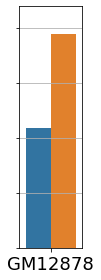

In [6]:
plt.figure(figsize=(1.4, 4))
sns.countplot(data=gm12878_bounds_fixed_hiccups.assign(name='GM12878'), x='name', hue='has_hiccup')
plt.xlabel("")
plt.ylabel("")
yticks, _ = plt.yticks()
plt.yticks(yticks, labels=[])
plt.grid(axis='y')
plt.ylim(0,4400)
plt.legend().set_visible(False)

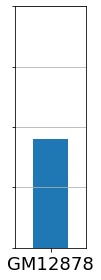

In [7]:
x = (gm12878_bounds_fixed_hiccups.has_hiccup.value_counts() / gm12878_bounds_fixed_hiccups.has_hiccup.value_counts().sum())[['Intersects HiCCUP']]
ax = x.plot.bar(figsize=(1.4, 4))
ax.set_xlabel("")
ax.set_yticklabels([])
ax.set_xticks([0])
ax.set_xticklabels(["GM12878"], rotation=0)
plt.grid(axis='y')
plt.ylim(0, 0.8)
plt.show()